In [4]:
# ============================== IMPORTS ==============================
import os, re
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from tqdm import tqdm
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras import mixed_precision

# Enable mixed precision globally
mixed_precision.set_global_policy('mixed_float16')

# ============================== CONFIG ==============================
DATA_DIR = "data"
IMG_SIZE = 256
NUM_CLASSES = 4
SEED = 42
EPOCHS = 40
SEQ_LEN = 10
BATCH_SIZE = 1

In [5]:
# ============================== LOAD DATA ==============================
# STAGE 1: 2D
def collect_data_pairs(split):
    rgb_paths = sorted(glob(os.path.join(DATA_DIR, split, '*_rgb.png')))
    mask_paths = [p.replace("_rgb.png", "_mask.png") for p in rgb_paths]
    return list(zip(rgb_paths, mask_paths))
    
# STAGE 2: SEQUENTIONAL
def collect_sequence_data_pairs(split, seq_len=SEQ_LEN, base_dir=DATA_DIR, sliding_stride=SEQ_LEN):
    rgb_paths = sorted(glob(os.path.join(base_dir, split, '*_rgb.png')))
    mask_paths = [p.replace("_rgb.png", "_mask.png") for p in rgb_paths]

    if len(rgb_paths) < seq_len:
        print(f"⚠️ Not enough frames in {split} to form a sequence of {seq_len}")
        return []

    sequence_pairs = []
    for i in range(0, len(rgb_paths) - seq_len + 1, sliding_stride):
        rgb_seq = rgb_paths[i:i + seq_len]
        mask_seq = mask_paths[i:i + seq_len]
        sequence_pairs.append((rgb_seq, mask_seq))

    return sequence_pairs

# ============================== DATASET ==============================
def preprocess_image(path):
    img = tf.image.decode_png(tf.io.read_file(path), channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img


def preprocess_mask(path):
    mask = np.array(Image.open(path).convert("L"))  # shape: (256, 256), int labels 0–3
    mask = tf.one_hot(mask, depth=NUM_CLASSES)      # shape: (256, 256, 4)
    return tf.cast(mask, tf.float32)

# STAGE 1: 2D
def tf_dataset(pairs, batch_size):
    def generator():
        for img_path, mask_path in pairs:
            yield preprocess_image(img_path), preprocess_mask(mask_path)

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, NUM_CLASSES), dtype=tf.float32),
        )
    )
    dataset = dataset.shuffle(buffer_size=1000, seed=SEED)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    # Print shape check
    for x, y in dataset.take(1):
        print(f"🔍 Feed sample X: {x.shape} | Y: {y.shape}")
    return dataset

# STAGE 2: SEQUENTIONAL

def tf_sequence_dataset(pairs, batch_size, seq_len=SEQ_LEN):
    def preprocess_sequence(rgb_seq, mask_seq):
        imgs = [preprocess_image(p) for p in rgb_seq]
        masks = [preprocess_mask(p) for p in mask_seq]
        return np.stack(imgs, axis=0), np.stack(masks, axis=0)

    def generator():
        for rgb_seq, mask_seq in pairs:
            yield preprocess_sequence(rgb_seq, mask_seq)

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(seq_len, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(seq_len, IMG_SIZE, IMG_SIZE, NUM_CLASSES), dtype=tf.float32),
        )
    )
    dataset = dataset.shuffle(1000, seed=SEED)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Print shape check
    for x, y in dataset.take(1):
        print(f"🔍 Feed sample X: {x.shape} | Y: {y.shape}")
    return dataset

# SEQUENCS

train_pairs = collect_sequence_data_pairs("train")
val_pairs = collect_sequence_data_pairs("val")
test_pairs = collect_sequence_data_pairs("test")

#print(f"✅ SEQ: Loaded {len(train_pairs)} training sequences, {len(val_pairs)} validation sequences. Data sets shapes:")

# DS: SEQ

train_ds = tf_sequence_dataset(train_pairs, BATCH_SIZE)
val_ds = tf_sequence_dataset(val_pairs, BATCH_SIZE)

pass

🔍 Feed sample X: (1, 10, 256, 256, 3) | Y: (1, 10, 256, 256, 4)
🔍 Feed sample X: (1, 10, 256, 256, 3) | Y: (1, 10, 256, 256, 4)


In [6]:
# ========= The model ============

# =========================
# Utilities: Norm, Dropout
# =========================
def _get_group_norm():
    try:
        from tensorflow_addons.layers import GroupNormalization
        return GroupNormalization
    except Exception:
        return None

GN = _get_group_norm()

def conv_norm_act_drop(x, filters, name_prefix, dropout_rate=0.25, groups=8):
    # Conv per-frame
    x = layers.TimeDistributed(
        layers.Conv2D(filters, (3, 3), padding='same'),
        name=f"{name_prefix}_conv"
    )(x)

    # --- FIX: apply normalization directly on 5D, not via TimeDistributed ---
    if GN is not None:
        # Normalize over channels (groups) for each (B,T,H,W, C)
        x = GN(groups=groups, axis=-1, name=f"{name_prefix}_gn", dtype='float32')(x)
    else:
        x = layers.LayerNormalization(axis=[2,3,4], name=f"{name_prefix}_ln", dtype='float32')(x)

    # Activation can operate on 5D directly
    x = layers.Activation('elu', name=f"{name_prefix}_act")(x)

    # Spatial dropout still needs per-frame application
    x = layers.TimeDistributed(
        layers.SpatialDropout2D(dropout_rate),
        name=f"{name_prefix}_sdrop"
    )(x)
    return x

# ======================================
# Timewise Squeeze-Excitation
# ======================================
def time_se(x, r=8, name="tse"):
    """Channel attention per frame."""
    c = x.shape[-1]
    s = layers.TimeDistributed(layers.GlobalAveragePooling2D(), name=f"{name}_gap")(x)  # (B,T,C)
    s = layers.TimeDistributed(layers.Dense(max(c // r, 1), activation='relu'), name=f"{name}_fc1")(s)
    s = layers.TimeDistributed(layers.Dense(c, activation='sigmoid'), name=f"{name}_fc2")(s)
    s = layers.TimeDistributed(layers.Reshape((1, 1, c)))(s)
    return layers.Multiply(name=f"{name}_scale")([x, s])

# =====================================
# Gradient checkpointing (recompute)
# =====================================
def _maybe_recompute(fn):
    """Wrap a function with tfa.utils.recompute_grad if available; else identity."""
    try:
        import tensorflow_addons as tfa
        return tfa.utils.recompute_grad(fn)
    except Exception:
        return fn  # no-op

def bclstm_block(x, filters, name_prefix, use_recompute=False, time_se_on=True, bidir=False):
    def core(inp):
        if bidir:
            y = layers.Bidirectional(
                layers.ConvLSTM2D(filters=filters // 2, kernel_size=(3,3),
                                  padding='same', return_sequences=True),
                name=f"{name_prefix}_bclstm")(inp)
        else:
            y = layers.ConvLSTM2D(filters=filters, kernel_size=(3,3),
                                  padding='same', return_sequences=True,
                                  name=f"{name_prefix}_clstm")(inp)
        if time_se_on:
            y = time_se(y, r=8, name=f"{name_prefix}_tse")
        return y
    return _maybe_recompute(core)(x) if use_recompute else core(x)


# ===================================
# UpSampling+Conv (no checkerboards)
# ===================================
def upsample_concat(x, skip, filters, name_prefix):
    x = layers.TimeDistributed(
            layers.UpSampling2D((2, 2), interpolation='bilinear'),
            name=f"{name_prefix}_upsample")(x)
    x = layers.TimeDistributed(
            layers.Conv2D(filters, (1, 1), padding='same'),
            name=f"{name_prefix}_proj")(x)
    return layers.Concatenate(name=f"{name_prefix}_concat")([x, skip])

# ==========================
# Deep supervision head(s)
# ==========================
def aux_head_upsampled(x, num_classes, name, target_size=256):
    """1x1 conv -> softmax -> upsample to 256x256 per time step."""
    # aux_head_upsampled:
    x = layers.TimeDistributed(layers.Conv2D(num_classes, (1, 1), padding='same'),
                           name=f"{name}_logits")(x)
    x = layers.TimeDistributed(layers.Activation('softmax', dtype='float32'),
                           name=f"{name}_softmax")(x)
    # Upsample to 256 if needed
    h = x.shape[2]
    if h is not None and h != target_size:
        scale = target_size // int(h)
        x = layers.TimeDistributed(
                layers.UpSampling2D(size=(scale, scale), interpolation='bilinear'),
                name=f"{name}_up")(x)
    return x

# ==========================
# Model builder (U-LSTM5^CE)
# ==========================
def build_ULSTM5_CE_DS(input_shape=(SEQ_LEN, 256, 256, 3),
                       num_classes=4,
                       enc_dec_dropout=0.25,
                       bottleneck_dropout=0.35,
                       groups=8,
                       add_time_se=True,
                       use_recompute_on_deep=True):
    """
    U-LSTM5 with:
      - GroupNorm (LN fallback), ELU, SpatialDropout2D
      - UpSampling+Conv in decoder
      - Deep supervision at dec2 & dec3
      - Optional Time-SE after each B-ConvLSTM
      - Gradient checkpointing on enc4/enc5/dec4 ConvLSTM blocks
    """
    inputs = layers.Input(shape=input_shape, name='input_seq')
    x = inputs

    # Encoder
    skips = []
    filter_sizes = [32, 64, 128, 192, 256]

    for i, f in enumerate(filter_sizes):
        dr = bottleneck_dropout if i == len(filter_sizes) - 1 else enc_dec_dropout
        x = conv_norm_act_drop(x, f, f"enc{i+1}_a", dropout_rate=dr, groups=groups)
        x = conv_norm_act_drop(x, f, f"enc{i+1}_b", dropout_rate=dr, groups=groups)

        # Recompute only on the deeper (VRAM-heavy) ConvLSTMs
        need_recompute = use_recompute_on_deep and (i >= 3)  # enc4, enc5
        x = bclstm_block(x, f, name_prefix=f"enc{i+1}",
                         use_recompute=need_recompute,
                         time_se_on=add_time_se,
                         bidir=False)
        skips.append(x)
        if i < len(filter_sizes) - 1:
            x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)),
                                       name=f"enc{i+1}_pool")(x)

    # Decoder with deep supervision taps
    dec_outputs = {}
    for i in reversed(range(len(filter_sizes) - 1)):
        f = filter_sizes[i]
        x = upsample_concat(x, skips[i], f, name_prefix=f"dec{i+1}")
        x = conv_norm_act_drop(x, f, f"dec{i+1}_a", dropout_rate=enc_dec_dropout, groups=groups)
        x = conv_norm_act_drop(x, f, f"dec{i+1}_b", dropout_rate=enc_dec_dropout, groups=groups)

        # Recompute only the first (deepest) decoder BCLSTM
        need_recompute = use_recompute_on_deep and (i == len(filter_sizes) - 2)  # dec4
        x = bclstm_block(x, f, name_prefix=f"dec{i+1}",
                         use_recompute=need_recompute,
                         time_se_on=add_time_se,
                         bidir=False)

        # Collect deep supervision at dec2 (128) and dec3 (64)
        if i == 2:   # dec3 output is 64x64
            dec_outputs['aux3'] = x
        if i == 1:   # dec2 output is 128x128
            dec_outputs['aux2'] = x

    # Heads
    # main head:
    main_logits = layers.TimeDistributed(layers.Conv2D(num_classes, (1, 1), padding='same'),
                                     name='main_logits')(x)
    main = layers.TimeDistributed(layers.Activation('softmax', dtype='float32'),
                              name='main')(main_logits)

    aux2 = aux_head_upsampled(dec_outputs['aux2'], num_classes, name='aux2')  # 128 -> 256
    aux3 = aux_head_upsampled(dec_outputs['aux3'], num_classes, name='aux3')  # 64  -> 256

    model = models.Model(inputs=inputs, outputs=[main, aux2, aux3], name='U_LSTM5_CE_DS')
    return model

# ==========================
# Losses and compile helper
# ==========================
def dice_per_class(y_true, y_pred, smooth=1e-6):
    # y_true/y_pred: (B,T,H,W,C)
    axes = [1,2,3]  # sum over T,H,W
    intersection = tf.reduce_sum(y_true * y_pred, axis=axes)
    denom = tf.reduce_sum(y_true + y_pred, axis=axes)
    dice = (2. * intersection + smooth) / (denom + smooth)  # (B,C)
    return dice

C

def ce_dice_hybrid(class_weights=None, alpha_ce=0.0, alpha_dice=1.0):
    """
    Combined categorical cross-entropy + weighted Dice.
    """
    def loss(y_true, y_pred):
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.05)
        ce = tf.reduce_mean(ce)
        dl = dice_loss_weighted(y_true, y_pred, class_weights=class_weights)
        return alpha_ce * ce + alpha_dice * dl
    return loss

# ==========================
# Example usage
# ==========================
model = build_ULSTM5_CE_DS(input_shape=(SEQ_LEN, 256, 256, 3),
                           num_classes=4,
                           enc_dec_dropout=0.25,
                           bottleneck_dropout=0.35,
                           add_time_se=True,
                           use_recompute_on_deep=True)
model.summary()

Model: "U_LSTM5_CE_DS"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_seq (InputLayer)         [(None, 10, 256, 25  0           []                               
                                6, 3)]                                                            
                                                                                                  
 enc1_a_conv (TimeDistributed)  (None, 10, 256, 256  896         ['input_seq[0][0]']              
                                , 32)                                                             
                                                                                                  
 enc1_a_gn (GroupNormalization)  (None, 10, 256, 256  64         ['enc1_a_conv[0][0]']            
                                , 32)                                                 

In [7]:
# ============================== TRAIN + SAVE ==============================
class DiceClass(tf.keras.metrics.Metric):
    def __init__(self, class_idx, name=None, **kwargs):
        name = name or f"dice_class_{class_idx}"
        super().__init__(name=name, **kwargs)
        self.class_idx = class_idx
        self.intersection = self.add_weight(name="intersection", initializer="zeros")
        self.union = self.add_weight(name="union", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_class = tf.argmax(y_true, axis=-1)
        y_pred_class = tf.argmax(y_pred, axis=-1)

        y_true_bin = tf.cast(tf.equal(y_true_class, self.class_idx), tf.float32)
        y_pred_bin = tf.cast(tf.equal(y_pred_class, self.class_idx), tf.float32)

        intersection = tf.reduce_sum(y_true_bin * y_pred_bin)
        union = tf.reduce_sum(y_true_bin) + tf.reduce_sum(y_pred_bin)

        self.intersection.assign_add(intersection)
        self.union.assign_add(union)

    def result(self):
        return (2. * self.intersection + 1e-6) / (self.union + 1e-6)

    def reset_state(self):  # Only reset this metric’s own vars
        self.intersection.assign(0.0)
        self.union.assign(0.0)

class AverageDice123(tf.keras.metrics.Metric):
    def __init__(self, name="average_dice123", **kwargs):
        super().__init__(name=name, **kwargs)
        self.dice1 = DiceClass(1)
        self.dice2 = DiceClass(2)
        self.dice3 = DiceClass(3)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.dice1.update_state(y_true, y_pred)
        self.dice2.update_state(y_true, y_pred)
        self.dice3.update_state(y_true, y_pred)

    def result(self):
        return (self.dice1.result() + self.dice2.result() + self.dice3.result()) / 3.0

    def reset_state(self):
        self.dice1.reset_state()
        self.dice2.reset_state()
        self.dice3.reset_state()

class PrintPreciseMetrics(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self._b_on, self._b_off = "\033[1m", "\033[0m"  # ANSI bold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # always start on a new, clean line and a header
        print("\n\n📊 Epoch {}".format(epoch+1))
        print("=" * 50)

        # print each metric on its own line (sorted for stable order)
        for k in sorted(logs.keys()):
            try:
                v = float(logs[k])
                print(f"{k}: {self._b_on}{v:.4f}{self._b_off}")
            except (TypeError, ValueError):
                print(f"{k}: {logs[k]}")
        print("", flush=True)


class EarlyStoppingFromEpoch(tf.keras.callbacks.EarlyStopping):
    def __init__(self, start_from_epoch=0, **kwargs):
        super().__init__(**kwargs)
        self.start_from_epoch = start_from_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch < self.start_from_epoch:
            return
        super().on_epoch_end(epoch, logs)

        
# ====== Top‑K (3) ModelCheckpoint by a metric ======
class TopKModelCheckpoint(tf.keras.callbacks.Callback):
    """
    Keeps the best K checkpoints on disk by a monitored metric.
    Validation runs and saved checkpoints use EMA weights (if available).
    """
    def __init__(self, dirpath, monitor='val_main_average_dice123', mode='max', k=10, prefix='model'):
        super().__init__()
        self.dirpath = dirpath
        self.monitor = monitor
        self.mode = mode
        self.k = k
        self.prefix = prefix
        self.saved = []  # list of tuples: (metric_value, filepath)
        os.makedirs(self.dirpath, exist_ok=True)
        self._has_ema = False

    def on_train_begin(self, logs=None):
        # Detect EMA optimizer support
        self._has_ema = hasattr(self.model.optimizer, "swap_weights")

    def _is_better(self, a, b):
        return (a > b) if self.mode == 'max' else (a < b)

    # --- Make validation (test) run with EMA weights ---
    def on_test_begin(self, logs=None):
        if self._has_ema:
            # Switch to EMA weights before validation starts
            self.model.optimizer.swap_weights()

    def on_test_end(self, logs=None):
        if self._has_ema:
            # Return to training (non‑EMA) weights after validation
            self.model.optimizer.swap_weights()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if self.monitor not in logs:
            return
        val = float(logs[self.monitor])

        # Save EMA weights (temporarily swap if currently on non‑EMA)
        swapped_now = False
        if self._has_ema:
            self.model.optimizer.swap_weights()
            swapped_now = True

        fname = f"{self.prefix}_epoch{epoch+1:03d}_{self.monitor}{val:.5f}.h5"
        fpath = os.path.join(self.dirpath, fname)
        self.model.save(fpath, include_optimizer=False)

        if swapped_now:
            # Revert to non‑EMA for continued training
            self.model.optimizer.swap_weights()

        # Track and prune
        self.saved.append((val, fpath))
        self.saved.sort(key=lambda x: x[0], reverse=(self.mode == 'max'))
        while len(self.saved) > self.k:
            _, worst_path = self.saved.pop(-1)
            try:
                os.remove(worst_path)
            except OSError:
                pass

        board = ", ".join([os.path.basename(p) for _, p in self.saved])
        print(f"[TopKModelCheckpoint] Kept top-{self.k}: {board}")

# ==== compile using CE+Dice hybrid & log metrics for all heads =====

def compile_model_with_hybrid(model,
                              lr=1e-4,
                              class_weights=(0.05, 0.35, 0.3, 0.3),
                              main_w=0.6, aux2_w=0.2, aux3_w=0.2,
                              use_ema=True, ema_decay=0.999):

    cw = tf.constant(class_weights, dtype=tf.float32)
    loss_fn = ce_dice_hybrid(class_weights=cw, alpha_ce=1.0, alpha_dice=0)

    # name‑agnostic losses
    losses = [loss_fn for _ in model.outputs]
    loss_weights = [main_w, aux2_w, aux3_w][:len(model.outputs)]

    # optimizer (EMA optional)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    if use_ema:
        try:
            import tensorflow_addons as tfa
            opt = tfa.optimizers.MovingAverage(opt, average_decay=ema_decay)
        except Exception:
            pass

    # build metrics dict keyed by actual output names
    def make_metrics():
        return [
            DiceClass(1, name="dice_glottis"),
            DiceClass(2, name="dice_right_fold"),
            DiceClass(3, name="dice_left_fold"),
            AverageDice123(name="average_dice123"),
        ]

    metrics = {out_name: make_metrics() for out_name in model.output_names}
    # Keras will prefix them as: main_average_dice123, aux2_up_average_dice123, ...

    model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights, metrics=metrics)
    return model

# ========= Training loop =========
def train_model(model, train_ds, val_ds, ckpt_dir, epochs=EPOCHS):
    # compile with hybrid loss + EMA
    compile_model_with_hybrid(model)

    # IMPORTANT: with multi-output models, Keras prefixes metric names with the output name.
    # We monitor the MAIN head's AverageDice123 on validation:
    monitor_metric = 'val_main_average_dice123'

    early_stop = EarlyStoppingFromEpoch(
        monitor=monitor_metric,
        mode='max',
        patience=5,
        restore_best_weights=True,
        start_from_epoch=15,
        verbose=1
    )

    # Keep the best 3 models for predict_ensemble
    top3_ckpt = TopKModelCheckpoint(
        dirpath=ckpt_dir,
        monitor=monitor_metric,
        mode='max',
        k=3,
        prefix='ulstm5ce_ds'
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop, top3_ckpt, PrintPreciseMetrics()]
    )
    return history

In [8]:
train_model(model, train_ds, val_ds, "WEIGHTS/U-LSTM5^CE_DS-Weighted_Dice_12.11.2025")

Epoch 1/40
[TopKModelCheckpoint] Kept top-3: ulstm5ce_ds_epoch001_val_main_average_dice1230.81454.h5104 - aux3_up_loss: 0.3040 - main_dice_glottis: 0.7263 - main_dice_right_fold: 0.7638 - main_dice_left_fold: 0.7616 - main_average_dice123: 0.7506 - aux2_up_dice_glottis: 0.7125 - aux2_up_dice_right_fold: 0.7719 - aux2_up_dice_left_fold: 0.7746 - aux2_up_average_dice123: 0.7530 - aux3_up_dice_glottis: 0.6445 - aux3_up_dice_right_fold: 0.7770 - aux3_up_dice_left_fold: 0.7779 - aux3_up_average_dice123: 0.7331   


📊 Epoch 1
aux2_up_average_dice123: 0.7530
aux2_up_dice_glottis: 0.7125
aux2_up_dice_left_fold: 0.7746
aux2_up_dice_right_fold: 0.7719
aux2_up_loss: 0.3104
aux3_up_average_dice123: 0.7331
aux3_up_dice_glottis: 0.6445
aux3_up_dice_left_fold: 0.7779
aux3_up_dice_right_fold: 0.7770
aux3_up_loss: 0.3040
loss: 0.3109
main_average_dice123: 0.7506
main_dice_glottis: 0.7263
main_dice_left_fold: 0.7616
main_dice_right_fold: 0.7638
main_loss: 0.3134
val_aux2_up_average_dice123: 0.8087
val_a

In [9]:
# ---- SWA: save a single averaged weights file from top-3 checkpoints ----
def extract_val_dice(p):
    m = re.search(r"val_main_average_dice123([0-9]*\.[0-9]+)", os.path.basename(p))
    return float(m.group(1)) if m else -1.0

def top_k_ckpts(ckpt_dir, k=3):
    paths = sorted(glob(os.path.join(ckpt_dir, "*.h5")))
    scored = [(p, extract_val_dice(p)) for p in paths]
    scored = [x for x in scored if x[1] >= 0]
    scored.sort(key=lambda x: x[1], reverse=True)
    return [p for p,_ in scored[:k]]

def save_swa_weights(base_model_builder, input_shape, weight_paths, out_path):
    """
    base_model_builder: function that builds the model
    input_shape: e.g., (SEQ_LEN, 256, 256, 3) so clone shapes are known
    """
    # Create a fresh model to hold the averaged weights
    model = base_model_builder(input_shape=input_shape)

    # Load all weights as lists of numpy arrays and average them
    weight_lists = []
    for wp in weight_paths:
        m = base_model_builder(input_shape=input_shape)
        m.load_weights(wp)
        weight_lists.append([w.numpy() for w in m.weights])

    avg_weights = []
    for weights_tuple in zip(*weight_lists):
        avg = np.mean(np.stack(weights_tuple, axis=0), axis=0)
        avg_weights.append(avg)

    # Assign to the fresh model
    assign_ops = []
    for var, val in zip(model.weights, avg_weights):
        assign_ops.append(var.assign(val))
    tf.keras.backend.batch_get_value(assign_ops)  # ensure assignment

    model.save_weights(out_path)
    print(f"✅ Saved SWA weights to: {out_path}")

# ---- build + save SWA once, then use your usual eval with load_weights(SWA_PATH) ----
# Example:
# from your_code import build_ULSTM5_CE_DS  # your builder from the previous message
# CKPT_DIR = "WEIGHTS/U-LSTM5^CE_DS-CCE"
# SWA_PATH  = os.path.join(CKPT_DIR, "top5_swa.h5")

"""
top5 = top_k_ckpts(CKPT_DIR, k=5)
print("Top-5 CCE:", top5)
save_swa_weights(build_ULSTM5_CE_DS, (SEQ_LEN, 256, 256, 3), top5, SWA_PATH)

SWA_PATH  = os.path.join(CKPT_DIR, "top3_swa.h5")

top3 = top_k_ckpts(CKPT_DIR, k=3)
print("Top-3 CCE:", top3)
save_swa_weights(build_ULSTM5_CE_DS, (SEQ_LEN, 256, 256, 3), top3, SWA_PATH)

CKPT_DIR = "WEIGHTS/U-LSTM5^CE_DS-Weighted_Dice"
SWA_PATH  = os.path.join(CKPT_DIR, "top5_swa.h5")

top5 = top_k_ckpts(CKPT_DIR, k=5)
print("Top-5 CCE:", top5)
save_swa_weights(build_ULSTM5_CE_DS, (SEQ_LEN, 256, 256, 3), top5, SWA_PATH)

SWA_PATH  = os.path.join(CKPT_DIR, "top3_swa.h5")

top3 = top_k_ckpts(CKPT_DIR, k=3)
print("Top-3 CCE:", top3)
save_swa_weights(build_ULSTM5_CE_DS, (SEQ_LEN, 256, 256, 3), top3, SWA_PATH)
"""
CKPT_DIR = r"WEIGHTS/U-LSTM5^CE_DS-Weighted_Dice_12.11.2025"
SWA_PATH  = os.path.join(CKPT_DIR, "top3_swa.h5")

top3 = top_k_ckpts(CKPT_DIR, k=3)
print("Top-3 CCE:", top3)
save_swa_weights(build_ULSTM5_CE_DS, (SEQ_LEN, 256, 256, 3), top3, SWA_PATH)

Top-3 CCE: ['WEIGHTS/U-LSTM5^CE_DS-Weighted_Dice_12.11.2025\\ulstm5ce_ds_epoch013_val_main_average_dice1230.89955.h5', 'WEIGHTS/U-LSTM5^CE_DS-Weighted_Dice_12.11.2025\\ulstm5ce_ds_epoch006_val_main_average_dice1230.89855.h5', 'WEIGHTS/U-LSTM5^CE_DS-Weighted_Dice_12.11.2025\\ulstm5ce_ds_epoch007_val_main_average_dice1230.89735.h5']
✅ Saved SWA weights to: WEIGHTS/U-LSTM5^CE_DS-Weighted_Dice_12.11.2025\top3_swa.h5


In [10]:
# ============================== EVALUATION ==============================
def dice_score(gt, pred, class_idx):
    gt_bin = (gt == class_idx).astype(np.uint8)
    pred_bin = (pred == class_idx).astype(np.uint8)
    intersection = np.sum(gt_bin * pred_bin)
    return (2. * intersection + 1e-6) / (np.sum(gt_bin) + np.sum(pred_bin) + 1e-6)

def apply_crf_and_morph(rgb_image, pred_probs, min_object_size=20):
    """
    Args:
        rgb_image: (256, 256, 3) uint8 - original frame
        pred_probs: (256, 256, 4) float32 - softmax probabilities
    Returns:
        postprocessed_mask: (256, 256) uint8 - label map after CRF + morphology
    """
    H, W = rgb_image.shape[:2]
    NUM_CLASSES = pred_probs.shape[-1]

    if pred_probs.shape != (H, W, NUM_CLASSES):
        raise ValueError(f"Expected pred_probs shape (H, W, C), got {pred_probs.shape}")

    probs = np.transpose(pred_probs, (2, 0, 1))  # (C, H, W)
    probs = np.clip(probs, 1e-6, 1 - 1e-6)

    # ========== CRF refinement ==========
    d = dcrf.DenseCRF2D(W, H, NUM_CLASSES)
    unary = unary_from_softmax(probs)
    unary = np.ascontiguousarray(unary)  # <-- Fix here
    d.setUnaryEnergy(unary)

    d.addPairwiseGaussian(sxy=3, compat=3)
    d.addPairwiseBilateral(sxy=50, srgb=13, rgbim=rgb_image, compat=10)

    Q = d.inference(5)
    refined = np.argmax(Q, axis=0).reshape((H, W)).astype(np.uint8)

    # ========== Morphological Cleanup ==========
    cleaned = np.zeros_like(refined)
    for cls in [1, 2, 3]:  # Glottis, Right Fold, Left Fold
        mask = (refined == cls).astype(np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
        mask = remove_small_objects(mask.astype(bool), min_size=min_object_size)
        cleaned[mask] = cls

    return cleaned

# Stage 1 pred mask saver:
def save_all_nn_masks_from_frames(model, test_pairs, output_dir):
    """
    Predicts and saves masks for each frame in the test dataset.
    Output: one PNG mask per frame, saved as {frame_id}_mask.png in output_dir.
    """
    os.makedirs(output_dir, exist_ok=True)
    print(f"📁 Saving prediction masks to: {output_dir}")

    for rgb_path, _ in tqdm(test_pairs, desc="🧠 Predicting NN masks"):
        img = preprocess_image(rgb_path)
        img_batch = np.expand_dims(img, axis=0)  # shape: (1, 256, 256, 3)

        # Run model inference
        preds = model.predict(img_batch, verbose=0)     # List of outputs
        main_pred = preds[0]                            # Use only final_out

        # Convert to segmentation mask
        pred_mask = np.argmax(main_pred[0], axis=-1)    # shape: (256, 256)

        # Save with consistent ID format
        sample_str = os.path.basename(rgb_path).split("_")[0]
        save_path = os.path.join(output_dir, f"{sample_str}_mask.png")
        Image.fromarray(pred_mask.astype(np.uint8)).save(save_path)


        
# Stage 2 pred mask saver:
def save_all_nn_masks_from_sequences(model, test_seq_pairs, output_dir, CRM=False, target_size=256):
    """
    Predicts and saves masks for each frame in the test dataset sequences.
    If CRM=True, applies CRF + Morphology before saving.
    Assumes model outputs: [main, aux2, aux3] with shapes (B,T,H,W,C).
    """
    os.makedirs(output_dir, exist_ok=True)
    print(f"📁 Saving prediction masks to: {output_dir}")

    for rgb_seq, _ in tqdm(test_seq_pairs, desc="🧠 Predicting NN masks"):
        # ----- build one (B=1) sequence batch -----
        imgs = [preprocess_image(p) for p in rgb_seq]               # each: (256,256,3) float32 [0..1]
        img_batch = np.expand_dims(np.stack(imgs, axis=0), axis=0)  # (1, T, 256, 256, 3)

        # ----- model forward -----
        y_all = model.predict(img_batch, verbose=0)
        # select MAIN head; y_main: (B, T, H, W, C)
        y_main = y_all[0] if isinstance(y_all, (list, tuple)) else y_all

        # ----- squeeze batch -> (T, H, W, C) -----
        if y_main.ndim != 5:
            raise ValueError(f"Expected main head to be 5D (B,T,H,W,C), got shape {y_main.shape}")
        y_main = y_main[0]  # remove batch axis ⇒ (T,H,W,C)

        # Sanity on time dim
        T = y_main.shape[0]
        if T != len(rgb_seq):
            # If your model predicts fewer/more frames (e.g., padding), clamp to the min
            T = min(T, len(rgb_seq))

        for i in range(T):
            # Per-frame probabilities: (H, W, C)
            prob = y_main[i]
            # Ensure spatial size = target_size for saving/CRF
            H, W = prob.shape[:2]
            if (H != target_size) or (W != target_size):
                # Safe resize of probabilities to target size
                prob = tf.image.resize(prob, (target_size, target_size), method='bilinear').numpy()

            if CRM:
                # Read corresponding RGB (for CRF) and resize to match prob
                rgb_np = np.array(Image.open(rgb_seq[i]).convert("RGB").resize((target_size, target_size)))
                # apply_crf_and_morph is expected to return a 2D label map (H,W) with {0..C-1}
                pred_mask = apply_crf_and_morph(rgb_np, prob)  # should be (H,W)
            else:
                # Argmax over classes -> (H,W)
                pred_mask = np.argmax(prob, axis=-1)

            # ---- Harden & sanitize shape/dtype for PIL ----
            pred_mask = np.squeeze(pred_mask)                 # remove any (1,1,*) accidents
            if pred_mask.ndim != 2:
                # Last-resort fix if axes got scrambled (avoid PIL (1,1,256) error)
                if pred_mask.shape[-1] == target_size and pred_mask.size == target_size * target_size:
                    pred_mask = pred_mask.reshape(target_size, target_size)
                else:
                    raise ValueError(f"Expected 2D mask, got shape {pred_mask.shape}")

            pred_mask = pred_mask.astype(np.uint8)            # PIL expects uint8
            # Optional clamp (safety): ensure labels in 0..3
            pred_mask = np.clip(pred_mask, 0, 255).astype(np.uint8)

            # ----- build filename & save -----
            sample_str = os.path.basename(rgb_seq[i]).split("_")[0]
            save_path = os.path.join(output_dir, f"{sample_str}_mask.png")
            Image.fromarray(pred_mask, mode='L').save(save_path)


def save_all_nn_landmarks_from_saved_masks(pred_dir, coord_dir="data/test/coord"):
    """
    Calculates and saves NN landmarks for all 1500 predicted test masks already saved in pred_dir.
    Does NOT require test_pairs or model.
    """
    os.makedirs(pred_dir, exist_ok=True)

    def parse_gt_coords(path):
        coords = {}
        with open(path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts[0] in ["P1", "P2"]:
                    coords[parts[0]] = tuple(map(float, parts[1:]))
                elif parts[0] in ["P3", "P4"]:
                    y, x = map(float, parts[1:])  # swap
                    coords[parts[0]] = (x, y)
        return coords

    def point_on_line(p, line, tol=1.5):
        if not line: return False
        (x1, y1), (x2, y2) = line
        if (x2 - x1) == 0:
            return abs(p[0] - x1) < tol
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
        return abs(p[1] - (m * p[0] + b)) < tol

    def find_extreme(pixels, axis, mode, line=None):
        if line is not None:
            pixels = [p for p in pixels if point_on_line((p[1], p[0]), line)]
        if pixels is None or len(pixels) == 0:
            return (0.0, 0.0)
        arr = np.array(pixels)
        idx = arr[:, axis].argmin() if mode == "min" else arr[:, axis].argmax()
        return tuple(arr[idx][::-1])  # (x, y)

    def valid(coords, key): return key in coords and not np.allclose(coords[key], (0, 0))

    for i in tqdm(range(1, 1501), desc="🧭 Landmark extraction from masks"):
        sid = f"{i:05d}"
        mask_path = os.path.join(pred_dir, f"{sid}_mask.png")
        coord_path = os.path.join(coord_dir, f"{sid}.txt")

        if not os.path.exists(mask_path) or not os.path.exists(coord_path):
            continue  # Skip if missing data

        coords = parse_gt_coords(coord_path)
        pred_mask = np.array(Image.open(mask_path))
        glottis_pixels = list(map(tuple, np.argwhere(pred_mask == 1)))

        GVA = [coords.get("P1", (0, 0)), coords.get("P2", (0, 0))] if all(valid(coords, k) for k in ["P1", "P2"]) else None
        GHA = [coords.get("P3", (0, 0)), coords.get("P4", (0, 0))] if all(valid(coords, k) for k in ["P3", "P4"]) else None

        def get_point(key, axis, mode, line):
            if valid(coords, key):
                pt = find_extreme(glottis_pixels, axis, mode, line)
                return pt if pt != (0.0, 0.0) else find_extreme(glottis_pixels, axis, mode)
            return (0.0, 0.0)

        p1nn = get_point("P1", axis=0, mode="min", line=GVA)
        p2nn = get_point("P2", axis=0, mode="max", line=GVA)
        p3nn = get_point("P3", axis=1, mode="min", line=GHA)
        p4nn = get_point("P4", axis=1, mode="max", line=GHA)

        def D(gt, nn):
            return np.linalg.norm(np.array(gt) - np.array(nn)) if not (
                np.allclose(gt, (0, 0)) or np.allclose(nn, (0, 0))) else 0.0

        D1 = D(coords.get("P1", (0, 0)), p1nn)
        D2 = D(coords.get("P2", (0, 0)), p2nn)
        D3 = D(coords.get("P3", (0, 0)), p3nn)
        D4 = D(coords.get("P4", (0, 0)), p4nn)

        out_path = os.path.join(pred_dir, f"{sid}.txt")
        with open(out_path, 'w') as f:
            f.write(f"P1 {p1nn[0]:.4f} {p1nn[1]:.4f}\n")
            f.write(f"P2 {p2nn[0]:.4f} {p2nn[1]:.4f}\n")
            f.write(f"P3 {p3nn[0]:.4f} {p3nn[1]:.4f}\n")
            f.write(f"P4 {p4nn[0]:.4f} {p4nn[1]:.4f}\n")
            if GVA:
                f.write(f"GVA {GVA[0][0]:.4f} {GVA[0][1]:.4f} {GVA[1][0]:.4f} {GVA[1][1]:.4f}\n")
            if GHA:
                f.write(f"GHA {GHA[0][0]:.4f} {GHA[0][1]:.4f} {GHA[1][0]:.4f} {GHA[1][1]:.4f}\n")
            f.write(f"D1 {D1:.4f}\n")
            f.write(f"D2 {D2:.4f}\n")
            f.write(f"D3 {D3:.4f}\n")
            f.write(f"D4 {D4:.4f}\n")

# Evaluate model performance comparing NN vs GT 

def evaluate_with_top_flop(nn_dir, pred_dir, gt_dir="data/test/coord"):

    dice_per_class = {i: [] for i in range(4)}
    D_vals = {f"D{i}": [] for i in range(1, 5)}
    per_frame_dc123 = {}

    for i in range(1, 1501):
        sid = f"{i:05d}"
        pred_mask_path = os.path.join(pred_dir, f"{sid}_mask.png")
        gt_mask_path = os.path.join("data", "test", f"{sid}_mask.png")
        txt_path = os.path.join(nn_dir, f"{sid}.txt")

        if not os.path.exists(pred_mask_path) or not os.path.exists(gt_mask_path):
            continue

        pred_mask = np.array(Image.open(pred_mask_path))
        gt_mask = np.array(Image.open(gt_mask_path))

        dc_vals = []
        for cls in range(4):
            gt_bin = (gt_mask == cls).astype(np.uint8)
            pr_bin = (pred_mask == cls).astype(np.uint8)
            denom = np.sum(gt_bin) + np.sum(pr_bin)
            if denom == 0:
                dice = np.nan
            else:
                inter = np.sum(gt_bin * pr_bin)
                dice = (2 * inter) / denom
            dice_per_class[cls].append(dice)
            dc_vals.append(dice)

        if all(np.isnan(val) for val in dc_vals[1:4]):
            continue

        avg_dc123 = np.nanmean(dc_vals[1:4])
        per_frame_dc123[sid] = avg_dc123

        try:
            with open(txt_path, "r") as f:
                lines = f.readlines()
        except FileNotFoundError:
            lines = []

        for line in lines:
            if line.startswith("D"):
                parts = line.strip().split()
                if len(parts) == 2:
                    key, val = parts
                    try:
                        D_vals[key].append(float(val))
                    except ValueError:
                        pass

        with open(txt_path, "w") as f:
            for line in lines:
                f.write(line)
            for cls in range(4):
                f.write(f"DC{cls} = {dc_vals[cls]:.4f}\n")

    print("\n📊 Per-Class Dice Score:")
    for cls in range(4):
        vals = np.array([v for v in dice_per_class[cls] if not np.isnan(v)])
        mean = np.mean(vals) if vals.size > 0 else float('nan')
        std = np.std(vals) if vals.size > 0 else float('nan')
        print(f"  Class {cls}: Dice = {mean:.4f} ± {std:.4f}")

    print(f"\n📏 Landmark P-Distances:")
    names = ["P1 (dorsal)", "P2 (ventral)", "P3 (right fold)", "P4 (left fold)"]
    for i in range(1, 5):
        vals = np.array([v for v in D_vals[f"D{i}"] if not np.isnan(v)])
        mean = np.mean(vals) if vals.size > 0 else float('nan')
        std = np.std(vals) if vals.size > 0 else float('nan')
        print(f"  D{i} {names[i-1]:<15}: {mean:6.2f} ± {std:6.2f} px")

    print("\n🧠 Top & Flop Predictions per 100-frame Sequence:")
    for seq in range(15):
        start = seq * 100 + 1
        end = (seq + 1) * 100 + 1
        segment = {k: v for k, v in per_frame_dc123.items() if start <= int(k) < end}
        if not segment:
            continue
        sorted_items = sorted(segment.items(), key=lambda item: item[1], reverse=True)
        top5 = sorted_items[:5]
        flop5 = sorted_items[-5:]

        print(f"\nSequence {seq + 1}:")
        print("Top 5 samples with best DC123:")
        for sid, val in top5:
            print(f"  {sid} (DC123 = {val:.4f})")
        print("Flop 5 samples with worst DC123:")
        for sid, val in flop5:
            print(f"  {sid} (DC123 = {val:.4f})")

# Plot Chosen Samples

def plot_gt_and_saved_nn_landmarks(sample_ids, nn_dir):
    def parse_landmarks(path, swap_p3p4=False):
        coords = {}
        with open(path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts[0] in ["P1", "P2", "P3", "P4"]:
                    x, y = map(float, parts[1:3])
                    if swap_p3p4 and parts[0] in ["P3", "P4"]:
                        coords[parts[0]] = (y, x)
                    else:
                        coords[parts[0]] = (x, y)
                elif parts[0] in ["GVA", "GHA"]:
                    coords[parts[0]] = tuple(map(float, parts[1:]))
        return coords

    colors = {"P1": "cyan", "P2": "red", "P3": "yellow", "P4": "blue"}

    fig, axs = plt.subplots(len(sample_ids), 3, figsize=(18, 4 * len(sample_ids)), dpi=100)
    if len(sample_ids) == 1:
        axs = np.expand_dims(axs, axis=0)

    for i, sid in enumerate(sample_ids):
        sid_str = f"{sid:05d}"
        rgb_path = f"data/test/{sid_str}_rgb.png"
        gt_mask_path = f"data/test/{sid_str}_mask.png"
        nn_mask_path = os.path.join(nn_dir, f"{sid_str}_mask.png")
        txt_gt = f"data/test/coord/{sid_str}.txt"
        txt_nn = os.path.join(nn_dir, f"{sid_str}.txt")

        img_rgb = np.array(Image.open(rgb_path).convert("RGB"))
        gt_mask = np.array(Image.open(gt_mask_path))
        pred_mask = np.array(Image.open(nn_mask_path))

        gt = parse_landmarks(txt_gt, swap_p3p4=True)
        nn = parse_landmarks(txt_nn)

        def line_from(coords, key):
            return [(coords[key][0], coords[key][1]), (coords[key][2], coords[key][3])] if key in coords else None

        gva = line_from(nn, "GVA")
        gha = line_from(nn, "GHA")

        ax1, ax3, ax2 = axs[i]
        ax1.imshow(img_rgb)
        ax1.axis("off")
        ax1.set_title(f"Sample {sid_str} - RGB")

        ax3.imshow(gt_mask, cmap="gray", vmin=0, vmax=3)
        ax3.axis("off")
        ax3.set_title("GT Mask")

        ax2.imshow(pred_mask, cmap="gray", vmin=0, vmax=3)
        ax2.axis("off")
        ax2.set_title("Predicted Mask")

        # GT and NN landmark overlays (as crosses)
        for ax, lm, suffix in [(ax1, gt, ""), (ax2, nn, "nn")]:
            for key in ["P1", "P2", "P3", "P4"]:
                if key in lm and not np.allclose(lm[key], (0, 0)):
                    x, y = lm[key]
                    ax.plot(x, y, marker="+", color=colors[key], markersize=6, mew=2)
                    ax.text(x + 2, y, key + suffix, color=colors[key], fontsize=9)

        for ax in [ax1, ax2]:
            if gva:
                ax.plot([gva[0][0], gva[1][0]], [gva[0][1], gva[1][1]], linestyle='dotted', color='white')
            if gha:
                ax.plot([gha[0][0], gha[1][0]], [gha[0][1], gha[1][1]], linestyle='dotted', color='white')

    plt.tight_layout()
    plt.show()

In [ ]:
# Initial Results - 1st iteration:

In [15]:
# ============================== EVALUATE ==============================
PRED_DIR = "NN_P_Landmarks/U-LSTM5^CE_DS-top3"
save_all_nn_masks_from_sequences(model, test_pairs, PRED_DIR)
save_all_nn_landmarks_from_saved_masks(PRED_DIR, "data/test/coord")
evaluate_with_top_flop(PRED_DIR, PRED_DIR)

📁 Saving prediction masks to: NN_P_Landmarks/U-LSTM5^CE_DS-top3


🧭 Landmark extraction from masks: 100%|██████████████████████████████████████████| 1500/1500 [00:07<00:00, 192.89it/s]



📊 Per-Class Dice Score:
  Class 0: Dice = 0.9951 ± 0.0026
  Class 1: Dice = 0.8612 ± 0.0950
  Class 2: Dice = 0.9203 ± 0.0249
  Class 3: Dice = 0.9064 ± 0.0341

📏 Landmark P-Distances:
  D1 P1 (dorsal)    :   1.82 ±   2.67 px
  D2 P2 (ventral)   :   6.55 ±  10.47 px
  D3 P3 (right fold):   1.68 ±   2.94 px
  D4 P4 (left fold) :   1.98 ±   4.17 px

🧠 Top & Flop Predictions per 100-frame Sequence:

Sequence 1:
Top 5 samples with best DC123:
  00009 (DC123 = 0.9110)
  00010 (DC123 = 0.9068)
  00008 (DC123 = 0.9065)
  00012 (DC123 = 0.9051)
  00007 (DC123 = 0.9038)
Flop 5 samples with worst DC123:
  00063 (DC123 = 0.8030)
  00088 (DC123 = 0.7948)
  00060 (DC123 = 0.7904)
  00074 (DC123 = 0.7803)
  00059 (DC123 = 0.7660)

Sequence 2:
Top 5 samples with best DC123:
  00101 (DC123 = 0.9004)
  00127 (DC123 = 0.8879)
  00126 (DC123 = 0.8874)
  00108 (DC123 = 0.8868)
  00125 (DC123 = 0.8867)
Flop 5 samples with worst DC123:
  00133 (DC123 = 0.8017)
  00147 (DC123 = 0.7970)
  00166 (DC123 = 0.78

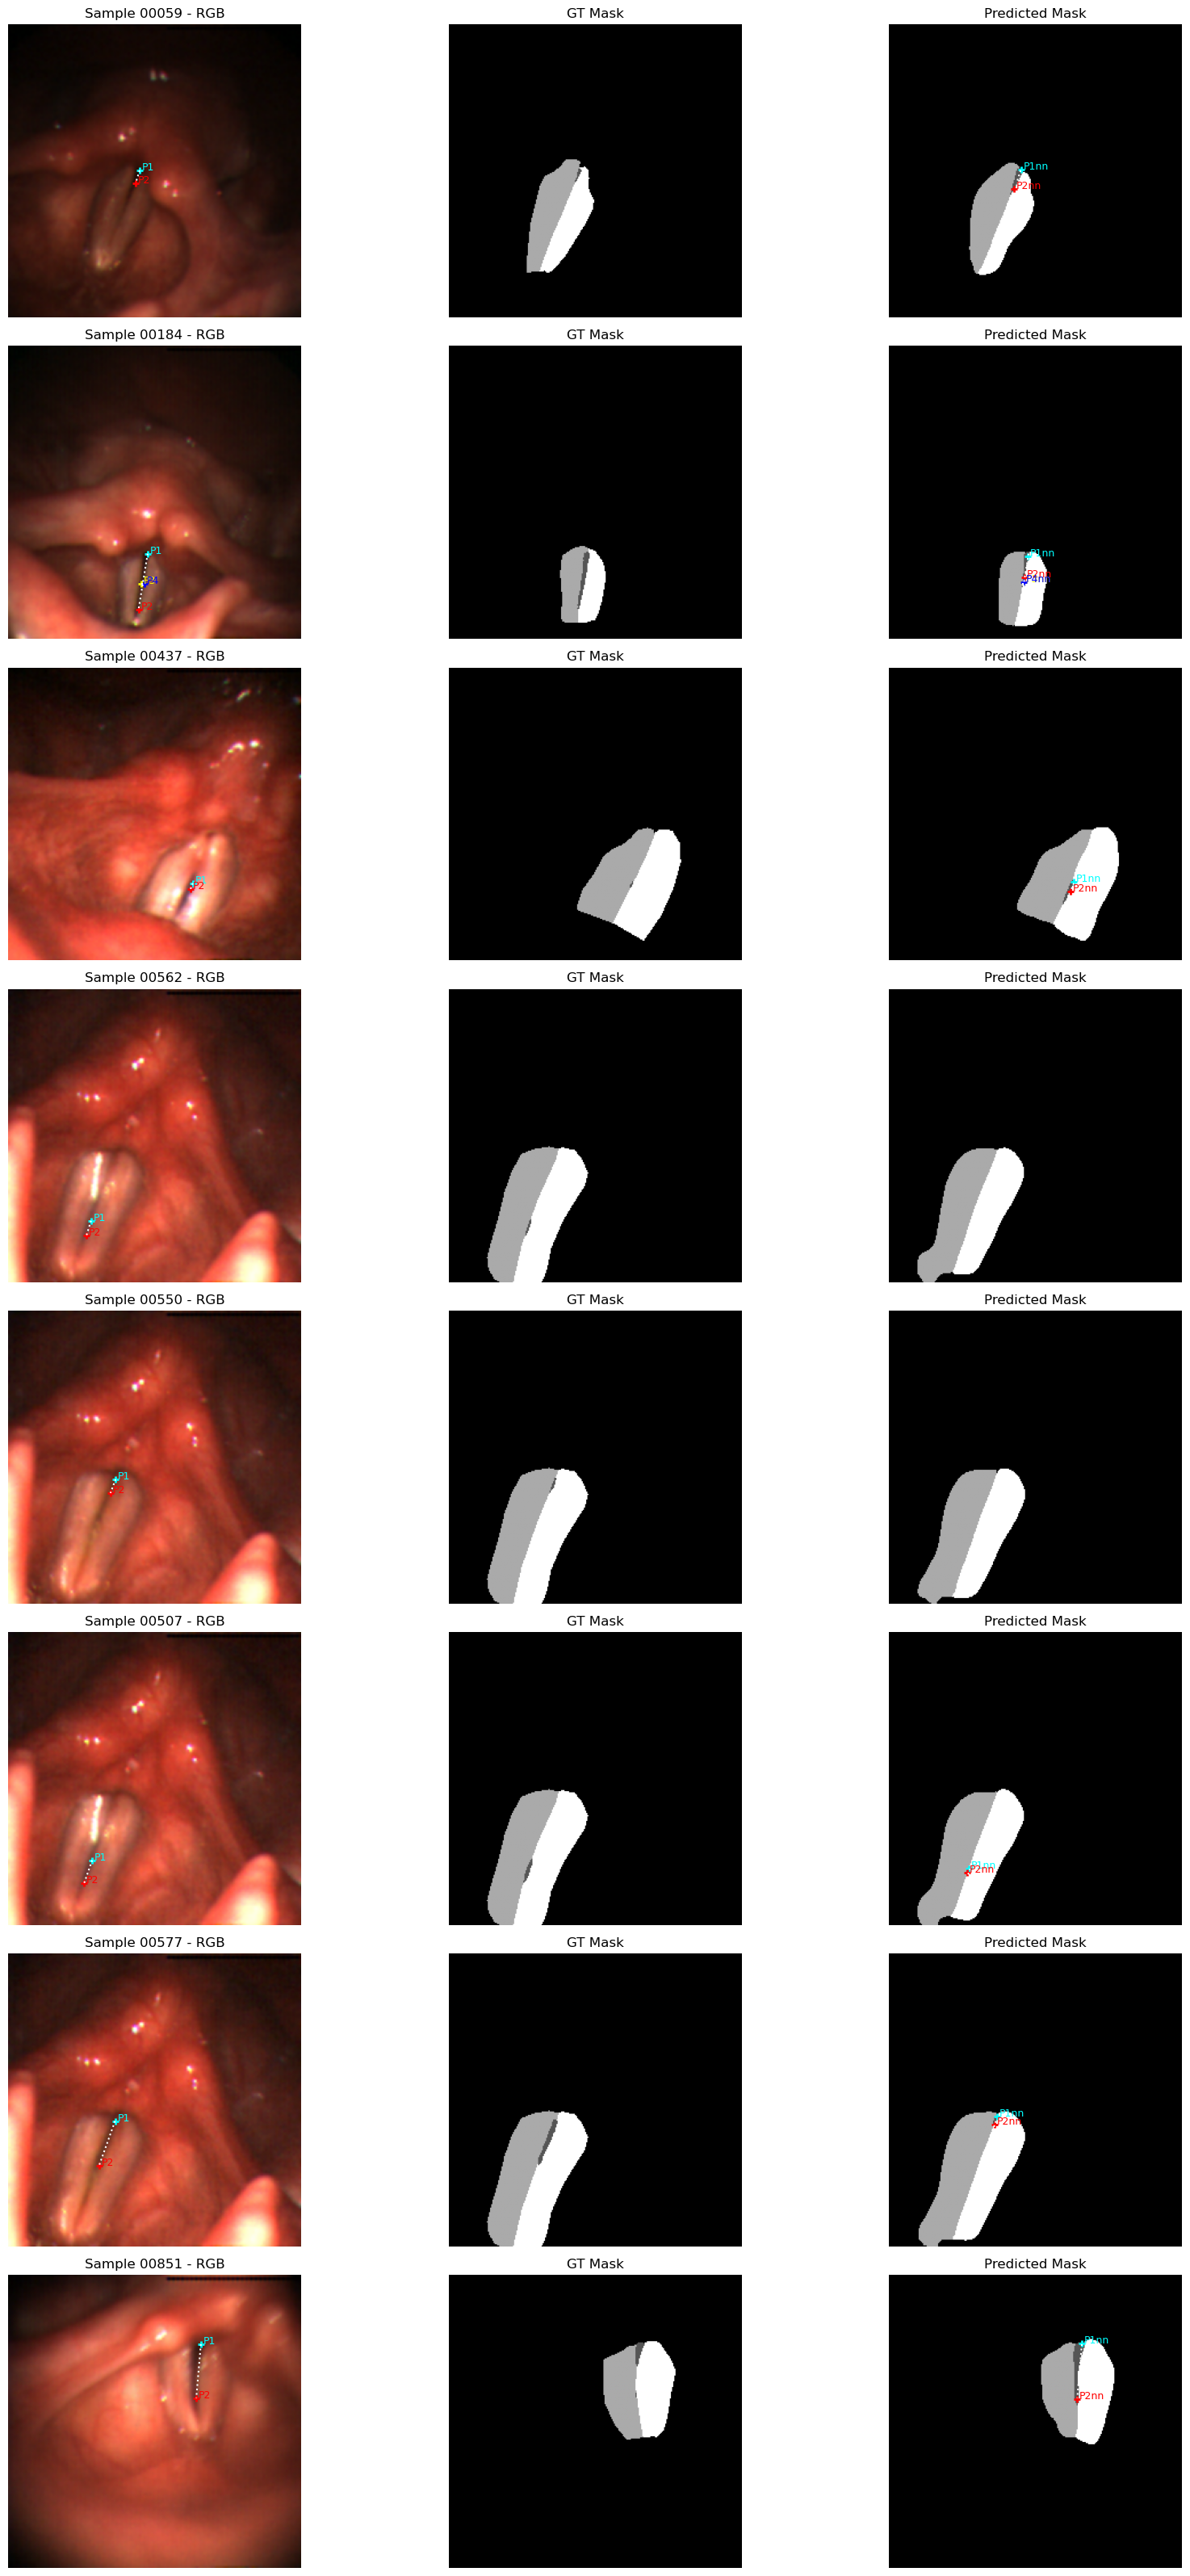

In [16]:
plot_gt_and_saved_nn_landmarks([59, 184, 437, 562, 550, 507, 577, 851], PRED_DIR)

In [ ]:
# Results after 2nd iteration (20.000 training pairs):

In [9]:
# Top 3 weights (chosen as best performer):
model.load_weights("WEIGHTS/U-LSTM5^CE_DS-Weighted_Dice_20.10.2025/top3_swa.h5")

In [10]:
# ============================== EVALUATE ==============================
PRED_DIR = "NN_P_Landmarks/U-LSTM5^CE_DS-top3-20.10.2025"
save_all_nn_masks_from_sequences(model, test_pairs, PRED_DIR)
save_all_nn_landmarks_from_saved_masks(PRED_DIR, "data/test/coord")
evaluate_with_top_flop(PRED_DIR, PRED_DIR)

📁 Saving prediction masks to: NN_P_Landmarks/U-LSTM5^CE_DS-top3-20.10.2025


🧭 Landmark extraction from masks: 100%|██████████████████████████████████████████| 1500/1500 [00:08<00:00, 185.41it/s]



📊 Per-Class Dice Score:
  Class 0: Dice = 0.9956 ± 0.0020
  Class 1: Dice = 0.8461 ± 0.1026
  Class 2: Dice = 0.9198 ± 0.0253
  Class 3: Dice = 0.9153 ± 0.0236

📏 Landmark P-Distances:
  D1 P1 (dorsal)    :   2.19 ±   3.21 px
  D2 P2 (ventral)   :   6.46 ±  10.61 px
  D3 P3 (right fold):   1.53 ±   2.40 px
  D4 P4 (left fold) :   1.87 ±   3.70 px

🧠 Top & Flop Predictions per 100-frame Sequence:

Sequence 1:
Top 5 samples with best DC123:
  00011 (DC123 = 0.9372)
  00012 (DC123 = 0.9249)
  00081 (DC123 = 0.9124)
  00082 (DC123 = 0.9074)
  00010 (DC123 = 0.9048)
Flop 5 samples with worst DC123:
  00063 (DC123 = 0.7715)
  00058 (DC123 = 0.7664)
  00088 (DC123 = 0.7639)
  00059 (DC123 = 0.7543)
  00074 (DC123 = 0.7484)

Sequence 2:
Top 5 samples with best DC123:
  00135 (DC123 = 0.8991)
  00115 (DC123 = 0.8954)
  00118 (DC123 = 0.8949)
  00155 (DC123 = 0.8933)
  00119 (DC123 = 0.8925)
Flop 5 samples with worst DC123:
  00166 (DC123 = 0.8367)
  00148 (DC123 = 0.8339)
  00147 (DC123 = 0.83

In [11]:
# 1 weight with the best DC (lower performance):
model.load_weights("WEIGHTS/U-LSTM5^CE_DS-Weighted_Dice_20.10.2025/best_ulstm5ce_ds_epoch010_val_main_average_dice1230.89567.h5")

In [12]:
# ============================== EVALUATE ==============================
PRED_DIR = "NN_P_Landmarks/U-LSTM5^CE_DS-top1-20.10.2025"
save_all_nn_masks_from_sequences(model, test_pairs, PRED_DIR)
save_all_nn_landmarks_from_saved_masks(PRED_DIR, "data/test/coord")
evaluate_with_top_flop(PRED_DIR, PRED_DIR)

📁 Saving prediction masks to: NN_P_Landmarks/U-LSTM5^CE_DS-top1-20.10.2025


🧭 Landmark extraction from masks: 100%|██████████████████████████████████████████| 1500/1500 [00:08<00:00, 176.58it/s]



📊 Per-Class Dice Score:
  Class 0: Dice = 0.9956 ± 0.0017
  Class 1: Dice = 0.8355 ± 0.1121
  Class 2: Dice = 0.9200 ± 0.0234
  Class 3: Dice = 0.9144 ± 0.0256

📏 Landmark P-Distances:
  D1 P1 (dorsal)    :   2.12 ±   3.15 px
  D2 P2 (ventral)   :   6.49 ±  10.92 px
  D3 P3 (right fold):   1.66 ±   2.10 px
  D4 P4 (left fold) :   1.87 ±   3.57 px

🧠 Top & Flop Predictions per 100-frame Sequence:

Sequence 1:
Top 5 samples with best DC123:
  00011 (DC123 = 0.9339)
  00012 (DC123 = 0.9150)
  00082 (DC123 = 0.9072)
  00081 (DC123 = 0.9034)
  00041 (DC123 = 0.8960)
Flop 5 samples with worst DC123:
  00048 (DC123 = 0.7352)
  00060 (DC123 = 0.7313)
  00088 (DC123 = 0.7230)
  00059 (DC123 = 0.7160)
  00074 (DC123 = 0.7093)

Sequence 2:
Top 5 samples with best DC123:
  00118 (DC123 = 0.9021)
  00137 (DC123 = 0.8983)
  00113 (DC123 = 0.8944)
  00155 (DC123 = 0.8940)
  00114 (DC123 = 0.8936)
Flop 5 samples with worst DC123:
  00166 (DC123 = 0.8524)
  00182 (DC123 = 0.8516)
  00186 (DC123 = 0.84

In [ ]:
# Results after 3rd extension (40.000 training pairs):

In [11]:
# Top 3 weights (chosen as best performer):
model.load_weights("WEIGHTS/U-LSTM5^CE_DS-Weighted_Dice_12.11.2025/top3_swa.h5")

In [12]:
# ============================== EVALUATE ==============================
PRED_DIR = "NN_P_Landmarks/U-LSTM5^CE_DS-top3-12.11.2025"
save_all_nn_masks_from_sequences(model, test_pairs, PRED_DIR)
save_all_nn_landmarks_from_saved_masks(PRED_DIR, "data/test/coord")
evaluate_with_top_flop(PRED_DIR, PRED_DIR)

📁 Saving prediction masks to: NN_P_Landmarks/U-LSTM5^CE_DS-top3-12.11.2025


🧭 Landmark extraction from masks: 100%|██████████████████████████████████████████| 1500/1500 [00:07<00:00, 192.28it/s]



📊 Per-Class Dice Score:
  Class 0: Dice = 0.9961 ± 0.0016
  Class 1: Dice = 0.8505 ± 0.0954
  Class 2: Dice = 0.9229 ± 0.0263
  Class 3: Dice = 0.9218 ± 0.0235

📏 Landmark P-Distances:
  D1 P1 (dorsal)    :   1.89 ±   3.01 px
  D2 P2 (ventral)   :   6.75 ±  10.55 px
  D3 P3 (right fold):   1.45 ±   2.35 px
  D4 P4 (left fold) :   1.98 ±   3.74 px

🧠 Top & Flop Predictions per 100-frame Sequence:

Sequence 1:
Top 5 samples with best DC123:
  00082 (DC123 = 0.9444)
  00083 (DC123 = 0.9381)
  00011 (DC123 = 0.9364)
  00012 (DC123 = 0.9332)
  00096 (DC123 = 0.9294)
Flop 5 samples with worst DC123:
  00063 (DC123 = 0.8029)
  00030 (DC123 = 0.8006)
  00088 (DC123 = 0.7978)
  00059 (DC123 = 0.7889)
  00074 (DC123 = 0.7881)

Sequence 2:
Top 5 samples with best DC123:
  00115 (DC123 = 0.9067)
  00134 (DC123 = 0.8958)
  00135 (DC123 = 0.8955)
  00113 (DC123 = 0.8949)
  00117 (DC123 = 0.8923)
Flop 5 samples with worst DC123:
  00147 (DC123 = 0.8435)
  00148 (DC123 = 0.8394)
  00166 (DC123 = 0.83

In [13]:
# 1 weight with the best DC (lower performance):
model.load_weights("WEIGHTS/U-LSTM5^CE_DS-Weighted_Dice_12.11.2025/ulstm5ce_ds_epoch013_val_main_average_dice1230.89955.h5")

In [14]:
# ============================== EVALUATE ==============================
PRED_DIR = "NN_P_Landmarks/U-LSTM5^CE_DS-top1-12.11.2025"
save_all_nn_masks_from_sequences(model, test_pairs, PRED_DIR)
save_all_nn_landmarks_from_saved_masks(PRED_DIR, "data/test/coord")
evaluate_with_top_flop(PRED_DIR, PRED_DIR)

📁 Saving prediction masks to: NN_P_Landmarks/U-LSTM5^CE_DS-top1-12.11.2025


🧭 Landmark extraction from masks: 100%|██████████████████████████████████████████| 1500/1500 [00:07<00:00, 201.43it/s]



📊 Per-Class Dice Score:
  Class 0: Dice = 0.9958 ± 0.0020
  Class 1: Dice = 0.8513 ± 0.0961
  Class 2: Dice = 0.9171 ± 0.0261
  Class 3: Dice = 0.9168 ± 0.0234

📏 Landmark P-Distances:
  D1 P1 (dorsal)    :   2.36 ±   4.07 px
  D2 P2 (ventral)   :   7.40 ±  10.49 px
  D3 P3 (right fold):   1.45 ±   2.15 px
  D4 P4 (left fold) :   1.92 ±   3.52 px

🧠 Top & Flop Predictions per 100-frame Sequence:

Sequence 1:
Top 5 samples with best DC123:
  00011 (DC123 = 0.9288)
  00082 (DC123 = 0.9232)
  00010 (DC123 = 0.9219)
  00005 (DC123 = 0.9218)
  00012 (DC123 = 0.9215)
Flop 5 samples with worst DC123:
  00088 (DC123 = 0.8181)
  00063 (DC123 = 0.8177)
  00058 (DC123 = 0.8156)
  00074 (DC123 = 0.8100)
  00059 (DC123 = 0.8088)

Sequence 2:
Top 5 samples with best DC123:
  00169 (DC123 = 0.8918)
  00116 (DC123 = 0.8903)
  00179 (DC123 = 0.8898)
  00124 (DC123 = 0.8888)
  00134 (DC123 = 0.8887)
Flop 5 samples with worst DC123:
  00166 (DC123 = 0.8262)
  00148 (DC123 = 0.8200)
  00186 (DC123 = 0.81